# Parameterize proxy error in temperature

## Imports and general definitions

Next to the imports necessary, this includes definitions for correcting the AIC and related parameters from the paper. For the mathematical descriptions and derivation, see the paper and the supplementary information.

In [2]:
import numpy as np
import pandas as pd
import os
from urllib import request
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=10, family='serif')

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker

from PIL import Image

colors = ['#5BC0EB', '#FDE74C', '#9BC53D', '#E55934', '#FA7921']

def correct_beta(beta_est, sigma_x, sigma_eta): 
    return beta_est * (1 + sigma_eta**2 / sigma_x**2)

def correct_sigma(beta_est, sigma_x, sigma_eta, sigma_eps_est):
    beta = correct_beta(beta_est, sigma_x, sigma_eta)
    return sigma_eps_est**2 - (beta**2*sigma_x**2*sigma_eta**2) / (sigma_x**2 + sigma_eta**2)

def correct_loglik(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est):
    return -sample_size / 2 * np.log(2 * np.pi * correct_sigma(beta_est, sigma_x, sigma_eta, sigma_eps_est)) - sample_size / 2

def correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=1):
    sigma_x = np.sqrt(sigma_x**2 - sigma_eta**2)
    return 2 * k - 2 * correct_loglik(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est)

# Create the folder where all the plots go in case it doesn't exist.
if not os.path.exists('plots'):
    os.makedirs('plots')

In [3]:
def ols(x, y): 
    beta = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    alpha = np.mean(y) - beta * np.mean(x)
    sigma = np.sqrt(np.sum((y - alpha - beta * x)**2)/(len(x)))
    aic = -2 * (-len(x) / 2 * np.log(2 * np.pi * sigma**2) - len(x) / 2) + 2 * 2

    r2 = 1 - np.sum((y - alpha - beta * x)**2) / np.sum((y - np.mean(y))**2)

    f_stat = (np.sum((y - np.mean(y))**2) - np.sum((y - alpha - beta * x)**2)) / (np.sum((y - alpha - beta * x)**2) / (len(y) - 2))
    # TODO: get p value

    return alpha, beta, sigma, aic, r2, f_stat

In [4]:

if not os.path.exists('data'):
    os.makedirs('data')

with TemporaryDirectory() as tmpdir:
    if not os.path.exists('data/climate_data.txt'):
        data_request = request.urlopen('https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_01757_18980301_20221231_hist.zip')
        with open(os.path.join(tmpdir, 'data.zip'), 'wb') as out:
            out.write(data_request.read())
        with ZipFile(os.path.join(tmpdir, 'data.zip')) as zip_file:
            filename = [z.filename for z in zip_file.filelist if z.filename.startswith('produkt_klima_tag')][0]
            zip_file.extract(filename, 'data')
            os.rename(os.path.join('data', filename), 'data/climate_data.txt')

    if not os.path.exists('data/ground_temp.txt'):
        data_request = request.urlopen('https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/soil_temperature/historical/tageswerte_EB_01757_19780101_20221231_hist.zip')
        with open(os.path.join(tmpdir, 'data.zip'), 'wb') as out:
            out.write(data_request.read())
        with ZipFile(os.path.join(tmpdir, 'data.zip')) as zip_file:
            filename = [z.filename for z in zip_file.filelist if z.filename.startswith('produkt_erdbo_tag')][0]
            zip_file.extract(filename, 'data')
            os.rename(os.path.join('data', filename), 'data/ground_temp.txt')

    if not os.path.exists('data/wood_anemone.txt'):
        data_request = request.urlopen('https://opendata.dwd.de/climate_environment/CDC/observations_germany/phenology/annual_reporters/wild/historical/PH_Jahresmelder_Wildwachsende_Pflanze_Busch-Windroeschen_1925_2022_hist.txt')
        with open('data/wood_anemone.txt', 'wb') as out:
            out.write(data_request.read())

## Data preprocessing

Reading and formatting the data from the weather station (air and ground temperature) as well as phenology data.
We are here using the mean air temperature in 2m height, filtering out for non-available data.
Ground temperature is also mean temperature from 5cm depth and also filtered for non-available data.

Then the mean temperature of each month is calculated and the data frames are merged together.
For the phenology data, we chose the temperature of march as a predictor, as the flowering dates of wood anemone are typically in april.

In [5]:
data = pd.read_csv('data/climate_data.txt', delimiter=';')
data.columns = data.columns.str.strip()
data.MESS_DATUM = pd.to_datetime(data.MESS_DATUM, format=r'%Y%m%d')
data = data[data['TMK'] != -999]
data['year'] = data.MESS_DATUM.dt.year
data['month'] = data.MESS_DATUM.dt.month


data_earth = pd.read_csv('data/ground_temp.txt', delimiter=';')
data_earth.columns = data_earth.columns.str.strip()
data_earth.MESS_DATUM = pd.to_datetime(data_earth.MESS_DATUM, format=r'%Y%m%d')
data = data.merge(data_earth, on=['STATIONS_ID', 'MESS_DATUM'])

data = data[data['V_TE005M'] != -999]

TMK_monthly = data.groupby(['year', 'month'])['TMK'].aggregate(lambda x: None if len(x) < 28 else x.mean()).dropna().reset_index()
TEK_monthly = data.groupby(['year', 'month'])['V_TE005M'].aggregate(lambda x: None if len(x) < 28 else x.mean()).dropna().reset_index()

monthly = TMK_monthly.merge(TEK_monthly, on=['year', 'month'])

monthly.to_csv('data/monthly.csv')

station_id = 12488
phen_data = pd.read_csv('data/wood_anemone.txt', delimiter=';')
phen_data.columns = phen_data.columns.str.strip()
phen_data = phen_data[phen_data.Stations_id == station_id]

phen_temp = phen_data.merge(monthly[monthly.month == 3], left_on='Referenzjahr', right_on='year')

phen_temp.to_csv('data/phen_temp.csv')

## Ground and air temperature in 2019

Two simple plots showing the ground and air temperature over the year 2019. Not necessary for any of the analysis, but quite nice.

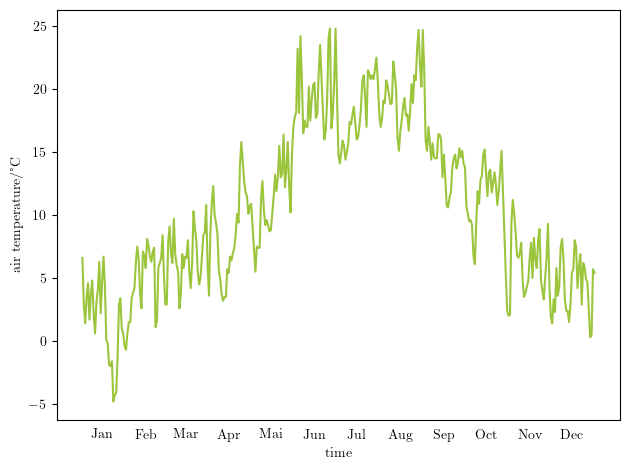

In [6]:
plt.plot(data.MESS_DATUM[data.year == 2019], data.TMK[data.year == 2019], color=colors[2])
plt.ylabel('air temperature/°C')
plt.xlabel('time')
plt.xticks(pd.to_datetime(['2019-01-15', 
    '2019-02-15', 
    '2019-03-15', 
    '2019-04-15', 
    '2019-05-15', 
    '2019-06-15', 
    '2019-07-15', 
    '2019-08-15', 
    '2019-09-15', 
    '2019-10-15', 
    '2019-11-15',
    '2019-12-15',
    ]), ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tight_layout()
plt.savefig('plots/air_temp_2019.pdf')

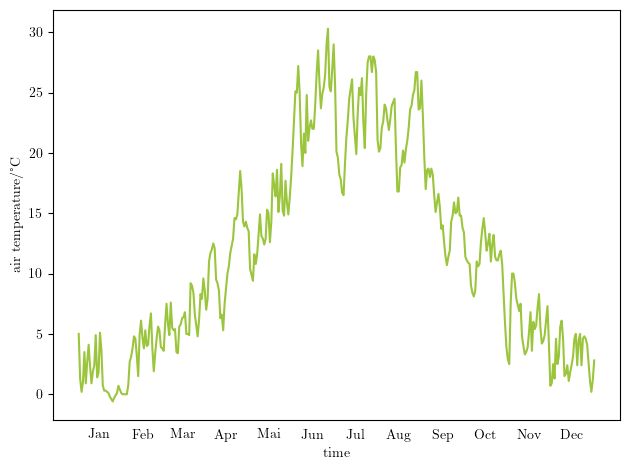

In [7]:
plt.plot(data.MESS_DATUM[data.year == 2019], data.V_TE005M[data.year == 2019], color=colors[2])
plt.ylabel('air temperature/°C')
plt.xlabel('time')
plt.xticks(pd.to_datetime(['2019-01-15', 
    '2019-02-15', 
    '2019-03-15', 
    '2019-04-15', 
    '2019-05-15', 
    '2019-06-15', 
    '2019-07-15', 
    '2019-08-15', 
    '2019-09-15', 
    '2019-10-15', 
    '2019-11-15',
    '2019-12-15',
    ]), ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tight_layout()
plt.savefig('plots/ground_temp_2019.pdf')

## Average yearly ground and air temperature and first flowering date phenology of wood anemone.

Again, not necessary for the analysis, but quite nice to see.

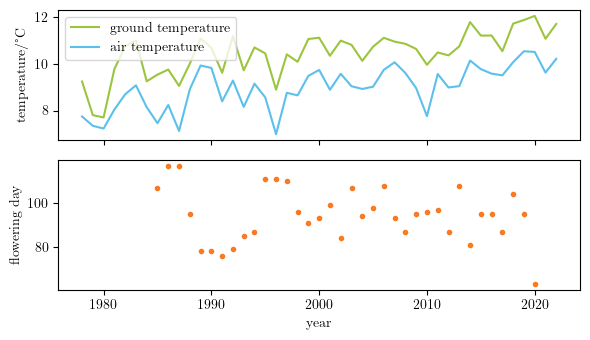

In [8]:
temp_years = data.groupby('year')[['V_TE005M', 'TMK']].mean().reset_index()

fig, axes = plt.subplots(2, 1, sharex=True)

fig.set_size_inches(6, 3.5)

ax = axes[0]

ax.plot(temp_years.year, temp_years.V_TE005M, color=colors[2], label='ground temperature')
ax.plot(temp_years.year, temp_years.TMK, color=colors[0], label='air temperature')

#ax.set_xlabel('year')
ax.set_ylabel('temperature/°C')

ax.legend(loc='upper left')

ax = axes[1]

ax.plot(phen_data.Referenzjahr[phen_data.Referenzjahr > 1978], phen_data.Jultag[phen_data.Referenzjahr > 1978], '.', color=colors[4])
ax.set_xlabel('year')
ax.set_ylabel('flowering day')

fig.tight_layout()
fig.savefig('plots/temp_years_hgw.pdf')

## Air temperature vs. ground temperature daily

Daily ground temperature vs air temperature. Not used later, as we use the average monthly temperature, but one can see that when using daily values, the error would be much larger.  
The regression here uses only values where the air temperature is above 0, as their is a clear change in the relationship below 0.

(-1.11440472484807, 1.2323283876745634, 2.1956581572426304, 64419.918419139714, 0.9182221715659469, 163954.95461240178)
std error: 2.1956581572426304


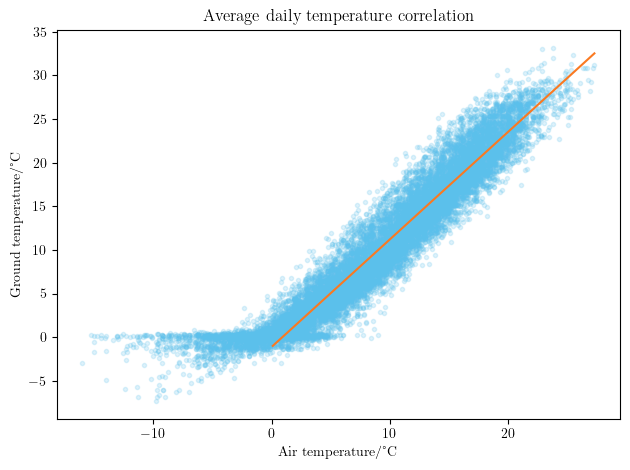

In [14]:
data_no_freeze = data[data.TMK > 0]

fit = ols(data_no_freeze['TMK'], data_no_freeze['V_TE005M'])
print(fit)
print(f'std error: {fit[2]}')

x = np.array([np.min(data_no_freeze['TMK']), np.max(data_no_freeze['TMK'])])
y = fit[1] * x + fit[0]

plt.plot(data['TMK'], data['V_TE005M'], '.', alpha=0.2, color=colors[0])
plt.plot(x, y, color=colors[4])
        
plt.xlabel('Air temperature/°C')
plt.ylabel('Ground temperature/°C')
plt.title('Average daily temperature correlation')
plt.tight_layout()
plt.savefig('plots/daily_temp_greifswald.svg')
plt.savefig('plots/daily_temp_greifswald.pdf')

## Air temperature vs. ground temperature monthly

The regression here uses only values where the air temperature is above 0, as their is a clear change in the relationship below 0.

The standard error from this is later used as an estimate of the measurement error of the actual regression.

(0.9275092214111553, 0.8103215781946809, 0.5499385013995384, 76.24709452928131, 0.9011721201422148, 382.9812913161612)
std error: 0.5499385013995384


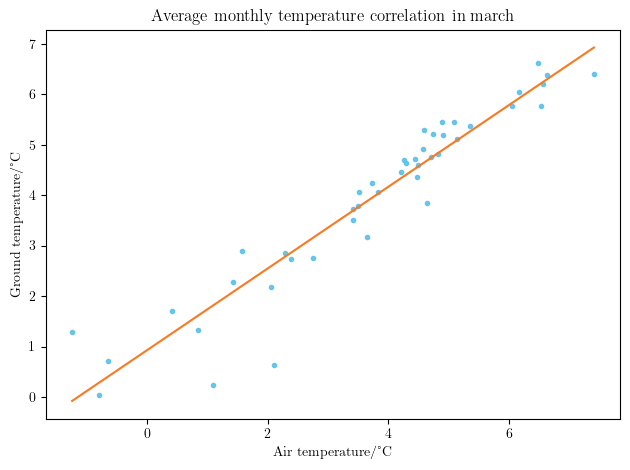

In [13]:
data_no_freeze = monthly[monthly.month == 3]

fit = ols(data_no_freeze['TMK'], data_no_freeze['V_TE005M'])
print(fit)
print(f'std error: {fit[2]}')

x = np.array([np.min(data_no_freeze['TMK']), np.max(data_no_freeze['TMK'])])
y = fit[1] * x + fit[0]

plt.plot(data_no_freeze['TMK'], data_no_freeze['V_TE005M'], '.', alpha=0.9, color=colors[0])
plt.plot(x, y, color=colors[4])

sigma_eta_actual = fit[2]        

plt.xlabel('Air temperature/°C')
plt.ylabel('Ground temperature/°C')
plt.title('Average monthly temperature correlation in march')
plt.tight_layout()
plt.savefig('plots/daily_temp_greifswald.svg')
plt.savefig('plots/daily_temp_greifswald.png', dpi=600)
plt.savefig('plots/daily_temp_greifswald.pdf')

std error: 0.7711319288651669
std error: 0.5002593081331248
std error: 0.5499385013995384
(0.9275092214111553, 0.8103215781946809, 0.5499385013995384, 76.24709452928131, 0.9011721201422148, 382.9812913161612)
76.24709452928131
std error: 0.6375405334979147
std error: 0.8782642459510266
std error: 0.9124151591289363
(-2.452248329554184, 1.4250907239562656, 0.9124151591289363, 120.8004955972415, 0.8085609882939988, 177.39101975986324)
120.8004955972415
std error: 0.8252462706931206
std error: 0.8448577132363996
std error: 0.6230248386765274
std error: 0.46577874334191427
(1.2133697877957914, 0.8702257111261024, 0.46577874334191427, 61.630669879169346, 0.8941734864717203, 354.87596803211807)
61.630669879169346
std error: 0.48668748979945453
std error: 0.5451937513285614


array([0.77113193, 0.50025931, 0.5499385 , 0.63754053, 0.87826425,
       0.91241516, 0.82524627, 0.84485771, 0.62302484, 0.46577874,
       0.48668749, 0.54519375])

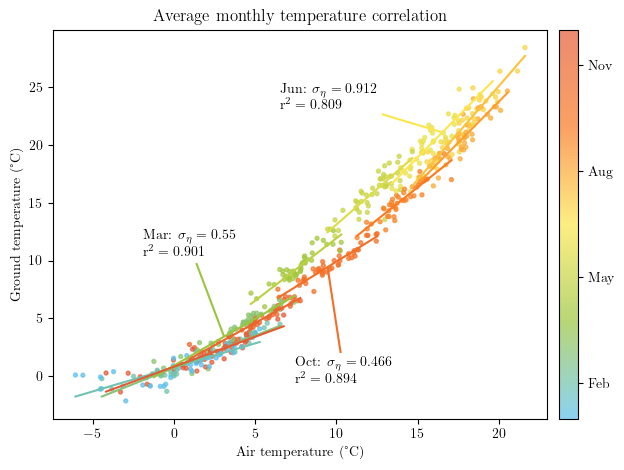

In [11]:
fig, ax = plt.subplots()

monthly_colors = LinearSegmentedColormap.from_list('mycmap', [colors[i] for i in [0, 2, 1, 4, 3]]) #colormaps['plasma'] #(np.linspace(0, 1, 12))


sigma_eta_actuals = np.zeros(12)

for month in range(1, 13):
        monthly_no_freeze = monthly[monthly.month == month]

        fit = ols(monthly_no_freeze.TMK, monthly_no_freeze.V_TE005M)
        #print(ols(monthly_no_freeze.TMK, monthly_no_freeze.V_TE005M))
        print(f'std error: {fit[2]}')
        sigma_eta_actuals[month - 1] = fit[2]

        x = np.array([np.min(monthly_no_freeze.TMK), np.max(monthly_no_freeze.TMK)])
        y = x * fit[1] + fit[0]

        ax.plot(x, y, color=monthly_colors(month / 12))

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        # place a text box in upper left in axes coords
        #ax.text(0.05, 0.95, f'$\sigma_\epsilon = {sigma_eta_actual:.3}$\n$' + r'\beta' + f' = {fit.params["TMK"]:.3}$\n$' + r'\alpha' + f' = {fit.params["const"]:.3}$\n$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
        #        verticalalignment='top', bbox=props)

        ax.set_xlabel('Air temperature (°C)')
        ax.set_ylabel('Ground temperature (°C)')
        ax.set_title('Average monthly temperature correlation')

        if month in [3, 10, 6]:
                print(fit)
                move = {
                3: {'x': -5, 'y': 7},
                10: {'x': -2, 'y': -10},
                6: {'x': -10, 'y': 2}
                }
                month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                ax.annotate(f"{month_names[month - 1]}: $\sigma_\eta={sigma_eta_actuals[month - 1]:.3}$\nr$^2 = {fit[4]:.3}$", 
                        [x[0] + (x[1] - x[0]) / 2, y[0] + (y[1] - y[0]) / 2],
                        xytext=[x[0] + (x[1] - x[0]) / 2 + move[month]['x'], y[0] + (y[1] - y[0]) / 2 + move[month]['y']],
                        arrowprops={
                                'arrowstyle':'-', 
                                'capstyle': 'butt',
                                'linewidth': plt.rcParams['lines.linewidth'], 
                                'color': monthly_colors(month/12), 
                                'shrinkA': plt.rcParams['xtick.major.bottom'] + 0.5, 
                                'shrinkB': 0
                        })
                print(fit[3])

scatter = ax.scatter(monthly.TMK, monthly.V_TE005M, c=monthly.month, s=8, cmap=monthly_colors, alpha=0.7)

plt.colorbar(scatter, ax=ax, ticks=[2, 5, 8, 11], format=mticker.FixedFormatter(['Feb', 'May', 'Aug', 'Nov']), fraction=0.1, pad=0.02)


sigma_eta_actual = sigma_eta_actuals[2]

fig.tight_layout()

fig.savefig('plots/monthly_temp_greifswald.svg')
fig.savefig('plots/monthly_temp_greifswald.pdf')
fig.savefig('plots/monthly_temp_greifswald.png')
sigma_eta_actuals

## Regress ground temperature against flowering date

This is to show that ground temperature is actually a better predictor, most likely it is not as good as expected because the ground temperature was not taken exactly at the flowers.

(116.27281206685772, -5.398087272113844, 7.756225987764459, 246.72040851200424, 0.5877535413883157, 47.049201904932225)
(116.27281206685772, -5.398087272113844, 7.756225987764459, 246.72040851200424, 0.5877535413883157, 47.049201904932225)
7.756225987764459


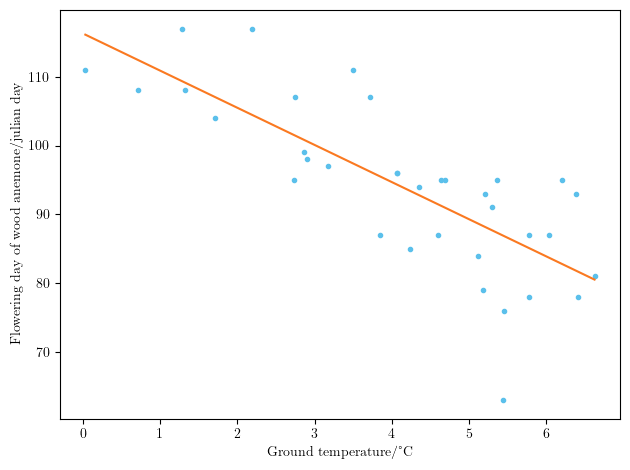

In [12]:
fit = ols(phen_temp.V_TE005M, phen_temp.Jultag)
print(fit)
print(fit)
print(fit[2])

x = np.array([np.min(phen_temp.V_TE005M), np.max(phen_temp.V_TE005M)])
y = fit[1] * x + fit[0]

plt.plot(phen_temp.V_TE005M, phen_temp.Jultag, '.', color=colors[0])
plt.plot(x, y, color=colors[4])
plt.xlabel('Ground temperature/°C')
plt.ylabel('Flowering day of wood anemone/julian day')
plt.tight_layout()
plt.savefig('plots/phen_ground_temp.svg')
plt.savefig('plots/phen_ground_temp.pdf')

## Regress air temperature against flowering date

This regression is assumed to be a "normal case" that people would do in general. It is obviously worse than using the ground temperature, but ground temperature is usually not as readily available.

(109.81695787782309, -4.106789668834167, 8.11967441000132, 249.92600124987047, 0.5482134946497779, 40.04335036394812)
8.11967441000132


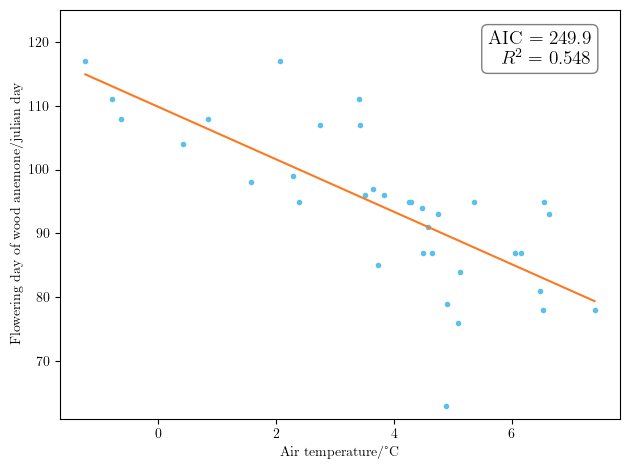

In [15]:

fit = ols(phen_temp.TMK, phen_temp.Jultag)
print(fit)
print(fit[2])

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit[1] * x + fit[0]

fig, ax = plt.subplots()

ax.set_ylim(61, 125)
ax.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
ax.plot(x, y, color=colors[4])
ax.set_xlabel('Air temperature/°C')
ax.set_ylabel('Flowering day of wood anemone/julian day')
fig.tight_layout()

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.95, f'AIC $ = {fit[3]:.4}$\n' + f'$R^2 = {fit[4]:.3}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)

fig.savefig('plots/phen_air_temp.svg')
fig.savefig('plots/phen_air_temp.pdf')

## Correct AIC for predictor error

We can now use our estimate of the predictor error to correct the AIC value. 

AIC difference: 3.0187746096490287


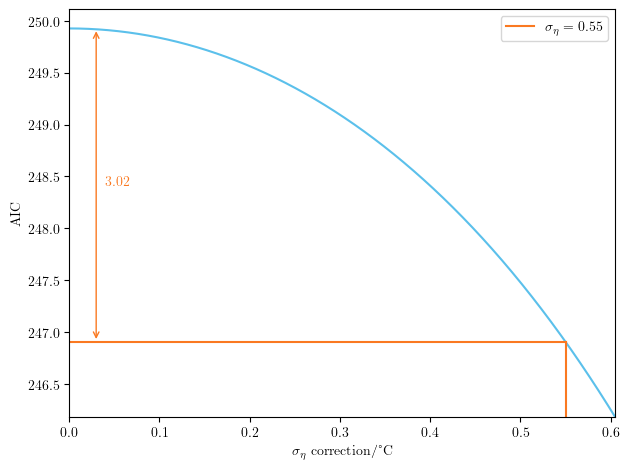

In [17]:
sigma_eta_actual = sigma_eta_actuals[2] #0.5499385013995384

sample_size = len(phen_temp)
sigma_x = np.std(phen_temp.TMK)
beta_est = fit[1]
sigma_eps_est = fit[2]
sigma_etas = np.linspace(0, sigma_eta_actual * 1.1 , 1000)

aics = np.zeros(sigma_etas.shape)

for i, sigma_eta in enumerate(sigma_etas):
    aics[i] = correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=2)

c_aic = correct_aic(sample_size, beta_est, sigma_x, sigma_eta_actual, sigma_eps_est, k=2)

print(f'AIC difference: {aics[0] - c_aic}')

plt.plot(sigma_etas, aics, color=colors[0])
plt.plot([sigma_eta_actual, sigma_eta_actual], [np.min(aics), c_aic], color=colors[4], label=f'$\sigma_\eta = {sigma_eta_actual:.3}$')
plt.plot([sigma_etas[0], sigma_eta_actual], [c_aic, c_aic], color=colors[4])

plt.annotate('', [0.03, c_aic], [0.03, aics[0]], arrowprops={'arrowstyle':'<->', 'color': colors[4]})
plt.annotate(f'{aics[0] - c_aic:.3}', [0.04, c_aic + (aics[0] - c_aic) / 2], color=colors[4])

plt.ylim(bottom=aics[-1])
plt.xlim(sigma_etas[0], sigma_etas[-1])
plt.legend()
plt.xlabel('$\sigma_\eta$ correction/°C')
plt.ylabel('AIC')
plt.tight_layout()
plt.savefig('plots/aic_correct_month.svg')
plt.savefig('plots/aic_correct_month.pdf')

(109.81695787782309, -4.106789668834167, 8.11967441000132, 249.92600124987047, 0.5482134946497779, 40.04335036394812)
8.11967441000132


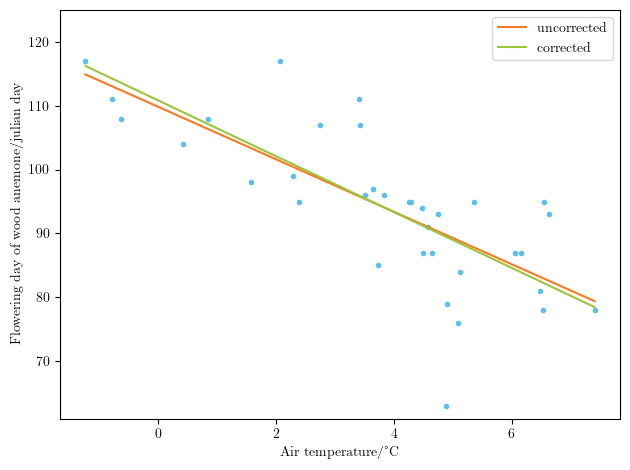

In [18]:
fit = ols(phen_temp.TMK, phen_temp.Jultag)
print(fit)
print(fit[2])

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit[1] * x + fit[0]

beta_c = correct_beta(fit[1], sigma_x, sigma_eta_actual)
alpha_c = np.mean(phen_temp.Jultag) - beta_c * np.mean(phen_temp.TMK)
y_correct = beta_c * x + alpha_c

plt.ylim(61, 125)
plt.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
plt.plot(x, y, color=colors[4], label='uncorrected')
plt.plot(x, y_correct, color=colors[2], label='corrected')
plt.legend()
plt.xlabel('Air temperature/°C')
plt.ylabel('Flowering day of wood anemone/julian day')
plt.tight_layout()
plt.savefig('plots/phen_air_temp_corrected.pdf')

## All the plots in one

std error: 0.7711319288651669
std error: 0.5002593081331248
std error: 0.5499385013995384
(0.9275092214111553, 0.8103215781946809, 0.5499385013995384, 76.24709452928131, 0.9011721201422148, 382.9812913161612)
76.24709452928131
std error: 0.6375405334979147
std error: 0.8782642459510266
std error: 0.9124151591289363
(-2.452248329554184, 1.4250907239562656, 0.9124151591289363, 120.8004955972415, 0.8085609882939988, 177.39101975986324)
120.8004955972415
std error: 0.8252462706931206
std error: 0.8448577132363996
std error: 0.6230248386765274
std error: 0.46577874334191427
(1.2133697877957914, 0.8702257111261024, 0.46577874334191427, 61.630669879169346, 0.8941734864717203, 354.87596803211807)
61.630669879169346
std error: 0.48668748979945453
std error: 0.5451937513285614
AIC difference: 3.0187746096490287


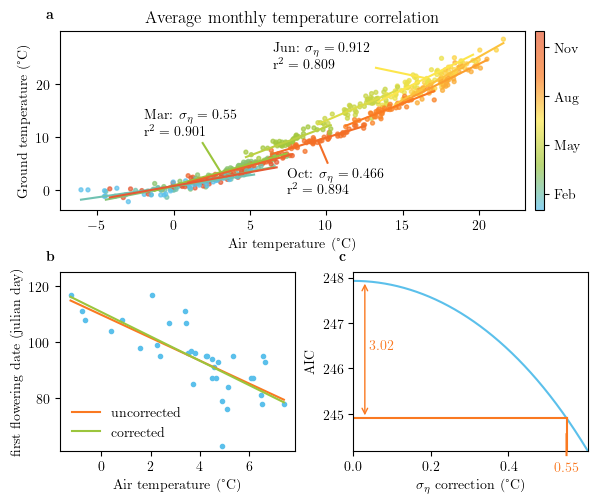

In [21]:
fig, axes = plt.subplot_mosaic([['a', 'a'], ['b', 'c']], 
                               gridspec_kw = dict(height_ratios=[1, 1], width_ratios=[1, 1], 
                                                  wspace=0.25, hspace=0.35, 
                                                  left=0.1,right=.98,top=.94,bottom=0.1))

fig.set_size_inches(6, 5)

for label, ax1 in axes.items():
    # label physical distance to the left and up:
    if label == 'legend':
        continue
    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
    ax1.text(0, 1.0, r'\textbf{' + label + '}', transform=ax1.transAxes + trans,
            weight='bold', va='bottom')



## wood anemone picture

"""

ax = axes['b']

im = Image.open('plots/wood_anemone.jpg')
ax.imshow(im, interpolation=None)

ax.set_axis_off()

"""

## temp-temp correlation -> get sigma eta

ax = axes['a']


monthly_colors = LinearSegmentedColormap.from_list('mycmap', [colors[i] for i in [0, 2, 1, 4, 3]]) #colormaps['plasma'] #(np.linspace(0, 1, 12))



# |---|---|---|---|---|---|---|---|---|---|---|  
#     2           5           8           11  

sigma_eta_actuals = np.zeros(12)

for month in range(1, 13):
        monthly_no_freeze = monthly[monthly.month == month]

        fit = ols(monthly_no_freeze.TMK, monthly_no_freeze.V_TE005M)
        #print(ols(monthly_no_freeze.TMK, monthly_no_freeze.V_TE005M))
        print(f'std error: {fit[2]}')
        sigma_eta_actuals[month - 1] = fit[2]

        x = np.array([np.min(monthly_no_freeze.TMK), np.max(monthly_no_freeze.TMK)])
        y = x * fit[1] + fit[0]

        ax.plot(x, y, color=monthly_colors(month / 12))

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        # place a text box in upper left in axes coords
        #ax.text(0.05, 0.95, f'$\sigma_\epsilon = {sigma_eta_actual:.3}$\n$' + r'\beta' + f' = {fit.params["TMK"]:.3}$\n$' + r'\alpha' + f' = {fit.params["const"]:.3}$\n$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
        #        verticalalignment='top', bbox=props)

        ax.set_xlabel('Air temperature (°C)')
        ax.set_ylabel('Ground temperature (°C)')
        ax.set_title('Average monthly temperature correlation')

        if month in [3, 10, 6]:
            print(fit)
            move = {
                3: {'x': -5, 'y': 7},
                10: {'x': -2, 'y': -10},
                6: {'x': -10, 'y': 2}
            }
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax.annotate(f"{month_names[month - 1]}: $\sigma_\eta={sigma_eta_actuals[month - 1]:.3}$\nr$^2 = {fit[4]:.3}$", 
                        [x[0] + (x[1] - x[0]) / 2, y[0] + (y[1] - y[0]) / 2],
                        xytext=[x[0] + (x[1] - x[0]) / 2 + move[month]['x'], y[0] + (y[1] - y[0]) / 2 + move[month]['y']],
                        arrowprops={
                            'arrowstyle':'-', 
                            'capstyle': 'butt',
                            'linewidth': plt.rcParams['lines.linewidth'], 
                            'color': monthly_colors(month/12), 
                            'shrinkA': plt.rcParams['xtick.major.bottom'] + 0.5, 
                            'shrinkB': 0
                        })
            print(fit[3])

scatter = ax.scatter(monthly.TMK, monthly.V_TE005M, c=monthly.month, s=8, cmap=monthly_colors, alpha=0.7)

plt.colorbar(scatter, ax=ax, ticks=[2, 5, 8, 11], format=mticker.FixedFormatter(['Feb', 'May', 'Aug', 'Nov']), fraction=0.1, pad=0.02)


sigma_eta_actual = sigma_eta_actuals[2]



"""
monthly_no_freeze = monthly[monthly.TMK > 0]

X = sm.add_constant(monthly_no_freeze.TMK)
fit = sm.OLS(monthly_no_freeze.V_TE005M, X).fit()
sigma_eta_actual = np.sqrt(fit.scale)

x = np.array([np.min(monthly_no_freeze.TMK), np.max(monthly_no_freeze.TMK)])
y = x * fit.params['TMK'] + fit.params['const']

ax.plot(monthly[monthly.TMK <= 0].TMK, monthly[monthly.TMK <= 0].V_TE005M, '.', color='gray', alpha=0.5)
ax.plot(monthly_no_freeze.TMK, monthly_no_freeze.V_TE005M, '.', color=colors[0], alpha=0.5)
ax.plot(x, y, color=colors[4])

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, f'$\sigma_\epsilon = {sigma_eta_actual:.3}$\n$' + r'\beta' + f' = {fit.params["TMK"]:.3}$\n$' + r'\alpha' + f' = {fit.params["const"]:.3}$\n$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)

ax.set_xlabel('Air temperature (°C)')
ax.set_ylabel('Ground temperature (°C)')
"""

## AIC correction

ax = axes['c']

fit = ols(phen_temp.TMK, phen_temp.Jultag)

sample_size = len(phen_temp)
sigma_x = np.std(phen_temp.TMK)
beta_est = fit[1]
sigma_eps_est = fit[2]
sigma_etas = np.linspace(0, sigma_eta_actual * 1.1 , 1000)

aics = np.zeros(sigma_etas.shape)

for i, sigma_eta in enumerate(sigma_etas):
    aics[i] = correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=1)

c_aic = correct_aic(sample_size, beta_est, sigma_x, sigma_eta_actual, sigma_eps_est, k=1)

print(f'AIC difference: {aics[0] - c_aic}')

ax.plot(sigma_etas, aics, color=colors[0])
ax.plot([sigma_eta_actual, sigma_eta_actual], [aics[-1], c_aic], color=colors[4], label=f'$\sigma_\eta = {sigma_eta_actual:.3}$°C')
ax.plot([sigma_etas[0], sigma_eta_actual], [c_aic, c_aic], color=colors[4])

ax.annotate('', [0.03, c_aic], [0.03, aics[0]], arrowprops={'arrowstyle':'<->', 'color': colors[4]})
ax.annotate(f'{aics[0] - c_aic:.3}', [0.04, c_aic + (aics[0] - c_aic) / 2], color=colors[4])

ax.set_ylim(bottom=aics[-1])
ax.set_xlim(sigma_etas[0], sigma_etas[-1])
ax.set_xlabel('$\sigma_\eta$ correction (°C)')
ax.set_ylabel('AIC')
ax.set_xticks([0.0, 0.2, 0.4])
ax.annotate(f'{sigma_eta_actual:.3}', [sigma_eta_actual / sigma_etas[-1], 0.1], xytext=[0, -13-(plt.rcParams['xtick.major.size'] + plt.rcParams['xtick.major.pad'])], 
            color=colors[4], textcoords='offset points', xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='top', 
            arrowprops={
                'arrowstyle':'-', 
                'capstyle': 'butt',
                'linewidth': plt.rcParams['lines.linewidth'], 
                'color': colors[4], 
                'shrinkA': plt.rcParams['xtick.major.bottom'] + 0.5, 
                'shrinkB': 0})

#ax.set_xticks([0, 0.5, 1, sigma_eta_actual])
#ax.get_xticklabels()[3].set_color(colors[4])



## air-temp-FFD correlation + corrected correlation

ax = axes['b']

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit[1] * x + fit[0]

beta_c = correct_beta(fit[1], sigma_x, sigma_eta_actual)
alpha_c = np.mean(phen_temp.Jultag) - beta_c * np.mean(phen_temp.TMK)
y_correct = beta_c * x + alpha_c

ax.set_ylim(61, 125)
ax.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
ax.plot(x, y, color=colors[4], label='uncorrected')
ax.plot(x, y_correct, color=colors[2], label='corrected')
ax.legend(frameon=False)
ax.set_xlabel('Air temperature (°C)')
ax.set_ylabel('first flowering date (julian day)')



fig.savefig('plots/all_together.pdf', dpi=600)